# Import Libraries

In [ ]:
# import libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.ensemble import ExtraTreesClassifier
import operator
from sklearn.preprocessing import StandardScaler
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# My Functions

In [ ]:
def datetounix(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop to convert Date to seconds
    for date in df['datetime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['datetime'] = unixtime
    return(df)

In [ ]:
# read train dataframe
# file_path = os.path.join(os.path.abspath(''), 'train.csv')
df_train = pd.read_csv("train.csv", encoding='ISO-8859-1', engine='c')

# read test dataframe
# file_path = os.path.join(os.path.abspath(''), 'test.csv')
df_test = pd.read_csv("test.csv", encoding='ISO-8859-1', engine='c')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   datetime                 26496 non-null  object 
 2   temperature              26496 non-null  float64
 3   var1                     26496 non-null  float64
 4   pressure                 26496 non-null  float64
 5   windspeed                26496 non-null  float64
 6   var2                     26496 non-null  object 
 7   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1.6+ MB


# Data Cleaning

Uploading and cleaning of data.

In [ ]:
# Converting to datetime
df_train['datetime'] = pd.to_datetime(df_train['datetime'])
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8568 entries, 0 to 8567
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ID           8568 non-null   int64         
 1   datetime     8568 non-null   datetime64[ns]
 2   temperature  8568 non-null   float64       
 3   var1         8568 non-null   float64       
 4   pressure     8568 non-null   float64       
 5   windspeed    8568 non-null   float64       
 6   var2         8568 non-null   object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 468.7+ KB


In [ ]:
# Creating features from DateTime for train data

df_test['Weekday'] = [datetime.weekday(date) for date in df_test.datetime]
df_test['Year'] = [date.year for date in df_test.datetime]
df_test['Month'] = [date.month for date in df_test.datetime]
df_test['Day'] = [date.day for date in df_test.datetime]
df_test['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_test.datetime]
df_test['Week'] = [date.week for date in df_test.datetime]
df_test['Quarter'] = [date.quarter for date in df_test.datetime]

# Creating features from DateTime for test data

df_train['Weekday'] = [datetime.weekday(date) for date in df_train.datetime]
df_train['Year'] = [date.year for date in df_train.datetime]
df_train['Month'] = [date.month for date in df_train.datetime]
df_train['Day'] = [date.day for date in df_train.datetime]
df_train['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in df_train.datetime]
df_train['Week'] = [date.week for date in df_train.datetime]
df_train['Quarter'] = [date.quarter for date in df_train.datetime]

# Data Preparation

In [ ]:
# Create Dummy Variables for Train set
df_train.loc[df_train.var2 == 'A', 'var2A'] = 1
df_train.loc[df_train.var2 == 'B', 'var2B'] = 1

df_train['var2A'].fillna(0, inplace=True)
df_train['var2B'].fillna(0, inplace=True)

df_train.drop(['var2'], axis=1, inplace=True)

# Create Dummy Variables for Test set
df_test.loc[df_test.var2 == 'A', 'var2A'] = 1
df_test.loc[df_test.var2 == 'B', 'var2B'] = 1

df_test['var2A'].fillna(0, inplace=True)
df_test['var2B'].fillna(0, inplace=True)

df_test.drop(['var2'], axis=1, inplace=True)

# Creating X_test
X_test = datetounix(df_test).drop(['ID'], axis=1).values

# Remove target column from the df
df_train_features = df_train.drop(['electricity_consumption', 'ID'], axis=1)

# Convet timestamp to seconds
df_train_features = datetounix(df_train_features)

# store features in X array
X = df_train_features.values
y = df_train['electricity_consumption'].values

# Visualisation of features

Feature ranking:
feature 0 : datetime (0.147607)
feature 4 : windspeed (0.144024)
feature 9 : Time (0.139217)
feature 3 : pressure (0.133401)
feature 2 : var1 (0.124573)
feature 1 : temperature (0.124343)
feature 8 : Day (0.062977)
feature 5 : Weekday (0.056614)
feature 10 : Week (0.032231)
feature 6 : Year (0.014913)
feature 7 : Month (0.011319)
feature 12 : var2A (0.005717)
feature 11 : Quarter (0.002684)
feature 13 : var2B (0.000380)


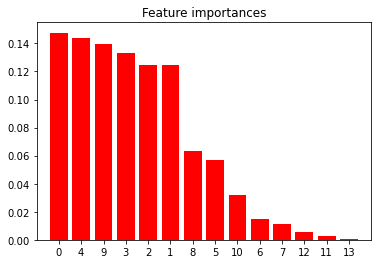

In [ ]:
# create an instance for tree feature selection
tree_clf = ExtraTreesClassifier()

# fit the model
tree_clf.fit(X, y)

# Preparing variables
importances = tree_clf.feature_importances_
feature_names = df_train_features.columns.tolist()

feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

# Plot the feature importances of the forest
plt.figure(0)
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
############ Data Scaling ###################
sc = StandardScaler()
X = sc.fit_transform(X)
X_test = sc.transform(X_test)

y_norm = (y - min(y))/(max(y) - min(y))
y_norm

array([0.03465347, 0.02970297, 0.04207921, ..., 0.03217822, 0.02970297,
       0.02970297])

# Implementing ANN

In [ ]:
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 10, kernel_initializer = 'uniform', activation = 'relu', input_dim = 14))

# Adding the second hidden layer
classifier.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mae'])

# Fitting the ANN to the training set
classifier.fit(X, y_norm, batch_size = 10, epochs = 100)

# Part 3 - Making the predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred * (max(y) - min(y))) + min(y)

predictions = [int(elem) for elem in y_pred]

df_solution = pd.DataFrame()
df_solution['ID'] = df_test.ID

# Prepare Solution dataframe
df_solution['electricity_consumption'] = predictions
df_solution['electricity_consumption'].unique()

df_solution

Epoch 1/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0125 - mae: 0.0712
Epoch 2/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0047 - mae: 0.0490
Epoch 3/100
2650/2650 [==============================] - 3s 1ms/step - loss: 0.0046 - mae: 0.0482
Epoch 4/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0045 - mae: 0.0478
Epoch 5/100
2650/2650 [==============================] - 4s 2ms/step - loss: 0.0045 - mae: 0.0475
Epoch 6/100
2650/2650 [==============================] - 4s 2ms/step - loss: 0.0045 - mae: 0.0473
Epoch 7/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0044 - mae: 0.0470
Epoch 8/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0044 - mae: 0.0470
Epoch 9/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0044 - mae: 0.0468
Epoch 10/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0044 - mae: 0.0467
Epoch 11/100
2650/2

2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451
Epoch 83/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451
Epoch 84/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451A: 1s - los
Epoch 85/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451
Epoch 86/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451
Epoch 87/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0450
Epoch 88/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451
Epoch 89/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0451
Epoch 90/100
2650/2650 [==============================] - 4s 1ms/step - loss: 0.0041 - mae: 0.0450
Epoch 91/100
2650/2650 [==============================] - 4s 2ms/step - loss: 0.0041 - mae: 0.0450
Epoch 92/100

,ID,electricity_consumption
0,552,176
1,553,175
2,554,176
3,555,175
4,556,270
...,...,...
8563,35059,177
8564,35060,177
8565,35061,176
8566,35062,176
